# Analysing air temperature over the last 150 years with EU data

## Step 1 - Get data from the **Source**

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Step 2 - Read data into a DataFrame

In [3]:
df = pd.read_csv('ECA_blended_custom/TG_STAID004563.txt', sep=',', names=['SOUID', 'DATE', 'TG', 'Q_TG'], skiprows=20)
df_header_0 = pd.read_csv('ECA_blended_custom/TG_STAID004563.txt', sep=',', names=['SOUID', 'DATE', 'TG', 'Q_TG'], header=0, skiprows=19)

# wanted to use header=0 and skirows=19 but somehow the column names are not valid in later calls, 
# although the visual output of the header is EXACTLY the same ... why is that? What is not shown here?

display(df)
display(df_header_0)

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53564,111448,20220827,205,0
53565,111448,20220828,177,0
53566,100133,20220829,166,0
53567,100133,20220830,172,0


,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53564,111448,20220827,205,0
53565,111448,20220828,177,0
53566,100133,20220829,166,0
53567,100133,20220830,172,0


## Step 3 - data wrangling

Exploratory analysis: basic modeling for getting an overview how the data looks like

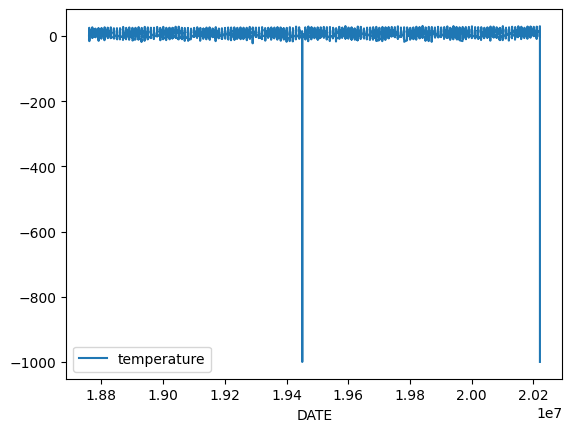

In [5]:
df['temperature'] = df['TG'] / 10

rawDataPlt = df.plot(x='DATE', y='temperature')

## Step 4 - convert date to timestamps

The date data is written as YYYYMMDD, which is not very readable

Pandas is good with timestamps, so the date column had to be cleaned to the right format

Then, the index can be set as an official pandas datetime type

<AxesSubplot: xlabel='datetime'>

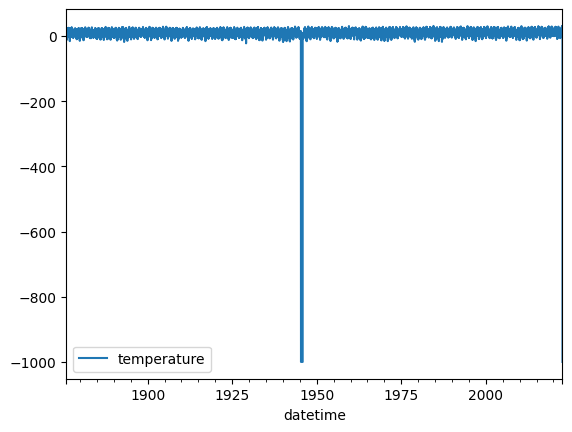

In [6]:
df2 = df.copy()


date_str = df2['DATE'].apply(str)
# I tried to overwrite the date with 
# df2['DATE'] = df2['DATE'].apply(str)
# but that did not work... 
# either had to apply .str[x:y] directly in one line
# or df2['year'] = df2['DATE'].apply(lambda i: i[0:4])
# or save the string date in a variable (chose this solution).
# Why is overwriting not working here?
# EDIT: another solution which works could have been the .astype(str) method....

df2['year'] = date_str.str[:4]

df2['month'] = date_str.str[4:6]

df2['day'] = date_str.str[6:]

df2['datetime'] = df2['year'] + '-' + df2['month'] + '-' + df2['day']

df2['datetime'] = pd.to_datetime(df2['datetime'])

df3 = df2.set_index('datetime', drop=True)
# Struggled a lot with this one... 
# Why do you name a function "set_index" when it is clearly not setting / applying on the df
# but rather just putting out a copy of a new dataframe, which has to be saved in a variable again...
# What I mean is: it's confusing that inplace=True is not the default for a funtcion named set_...

df3.plot(y='temperature')

## Step 5 - Missing values

Some missing values (here -999.9) can be replaced by the overall mean temperature

In [7]:
overall_mean_temp = df3['temperature'].mean()

df3['temperature'] = df3['temperature'].replace(-999.9, overall_mean_temp)

display(df3)

,SOUID,DATE,TG,Q_TG,temperature,year,month,day
datetime,,,,,,,,
1876-01-01,127488,18760101,22,0,2.200000,1876,01,01
1876-01-02,127488,18760102,25,0,2.500000,1876,01,02
1876-01-03,127488,18760103,3,0,0.300000,1876,01,03
1876-01-04,127488,18760104,-58,0,-5.800000,1876,01,04
1876-01-05,127488,18760105,-98,0,-9.800000,1876,01,05
...,...,...,...,...,...,...,...,...
2022-08-27,111448,20220827,205,0,20.500000,2022,08,27
2022-08-28,111448,20220828,177,0,17.700000,2022,08,28
2022-08-29,100133,20220829,166,0,16.600000,2022,08,29


## Step 6 - Cut off last year

To have clean data in a later stage, the data from the running year gets removed (cutting it off)

In [8]:
df4 = df3.loc[:'2021-12-31']

display(df4)

,SOUID,DATE,TG,Q_TG,temperature,year,month,day
datetime,,,,,,,,
1876-01-01,127488,18760101,22,0,2.2,1876,01,01
1876-01-02,127488,18760102,25,0,2.5,1876,01,02
1876-01-03,127488,18760103,3,0,0.3,1876,01,03
1876-01-04,127488,18760104,-58,0,-5.8,1876,01,04
1876-01-05,127488,18760105,-98,0,-9.8,1876,01,05
...,...,...,...,...,...,...,...,...
2021-12-27,111448,20211227,-39,0,-3.9,2021,12,27
2021-12-28,111448,20211228,-5,0,-0.5,2021,12,28
2021-12-29,111448,20211229,45,0,4.5,2021,12,29


## Step 7 - Aggregate

One value per year using median

<AxesSubplot: xlabel='datetime'>

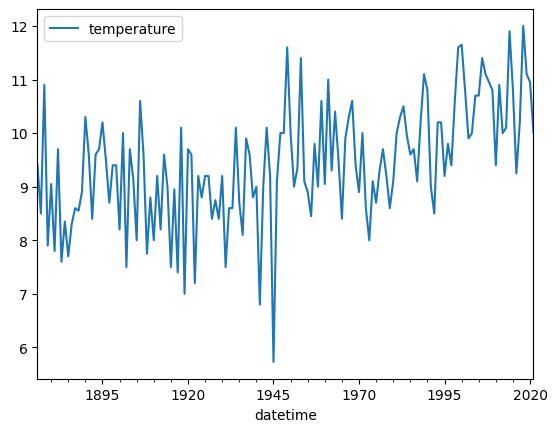

In [13]:
# Possible solution:
# df5_yearly = df4.groupby('year')['temperature'].median()

# Better solution for timestamps:
df5_yearly = df4.resample('Y').median()

df5_yearly.plot(y='temperature')

## Step 8 - Heatmap

<AxesSubplot: title={'center': 'yearly median temperature in Berlin-Dahlem'}, xlabel='year'>

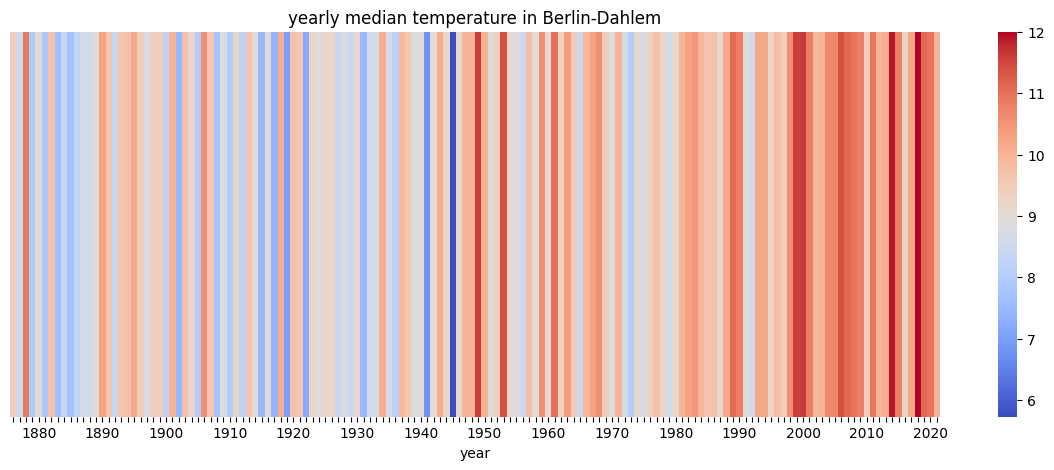

In [25]:
# Storing yearly median data in single column DataFrame

df6 = df4.groupby('year')[['year', 'temperature']].median().transpose()

# I tried to use this solution at first:
# df6 = df5_yearly[['temperature']].transpose()
# because the yearly data is already stored from the Step 7,
# but the df5_yearly does not include the year column. 
# I also could have taken the year from the datetime column,
# but that would be another step again, so no time would have been saved there.
# Therefore I just used the good ol' groupby function.

cmap = plt.get_cmap('coolwarm')

xlabels = [x if int(x) % 10 == 0 else '' for x in df6.columns]


plt.figure(figsize=(15, 5))
plt.title('yearly median temperature in Berlin-Dahlem')
sns.heatmap(df6, cmap=cmap, yticklabels=[], xticklabels=xlabels)

# My questions:
# 1: Are there simple ways to rotate the tick label? couldnt find one
# EDIT: no
# 2: Are there simple ways to drop every 5th tick label to make it more readable? couldnt find one
# EDIT: yes, cticklabels can be a list compreheension, see above
